# Aulas 2 e 3 Police Dataset 🚨👮🏻‍♀️🚔🚨

### Extract - Transform

Perguntas:

1. Os resultados das paradas refletem a gravidade dos motivos da parada?
2. Os dados estão desbalanceados?
3. A polícia tem algum viés com algum grupo?

## Aula 2 - Extração de Dados - Parte 1

In [16]:
import pandas as pd
import numpy as np

pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt

%matplotlib inline
import seaborn as sns

In [17]:
csv_path = "../data/police.csv"
df = pd.read_csv(csv_path)
df.fillna("NA")
df.head()

,stop_date,stop_time,county_name,driver_gender,driver_age_raw,driver_age,driver_race,violation_raw,violation,search_conducted,search_type,stop_outcome,is_arrested,stop_duration,drugs_related_stop
0,2005-01-02,01:55,NaN,M,1985.0,20.0,White,Speeding,Speeding,False,NaN,Citation,False,0-15 Min,False
1,2005-01-18,08:15,NaN,M,1965.0,40.0,White,Speeding,Speeding,False,NaN,Citation,False,0-15 Min,False
2,2005-01-23,23:15,NaN,M,1972.0,33.0,White,Speeding,Speeding,False,NaN,Citation,False,0-15 Min,False
3,2005-02-20,17:15,NaN,M,1986.0,19.0,White,Call for Service,Other,False,NaN,Arrest Driver,True,16-30 Min,False
4,2005-03-14,10:00,NaN,F,1984.0,21.0,White,Speeding,Speeding,False,NaN,Citation,False,0-15 Min,False


In [18]:
display(df.describe())
display(df.describe(include="O"))

,county_name,driver_age_raw,driver_age
count,0.0,86414.000000,86120.000000
mean,NaN,1970.491228,34.011333
std,NaN,110.914909,12.738564
min,NaN,0.000000,15.000000
25%,NaN,1967.000000,23.000000
50%,NaN,1980.000000,31.000000
75%,NaN,1987.000000,43.000000
max,NaN,8801.000000,99.000000


,stop_date,stop_time,driver_gender,driver_race,violation_raw,violation,search_type,stop_outcome,is_arrested,stop_duration
count,91741,91741,86406,86408,86408,86408,3196,86408,86408,86408
unique,3768,1436,2,5,12,6,24,6,2,5
top,2012-01-11,11:00,M,White,Speeding,Speeding,Incident to Arrest,Citation,False,0-15 Min
freq,69,323,62895,62158,48463,48463,1219,77006,83479,69543


In [19]:
print("Violations:")
print(df.violation.unique())
print("Stop Outcomes:")
print(df.stop_outcome.unique())
print("Stop Durations:")
print(df.stop_duration.unique())
print("Search Conducted:")
print(df.search_conducted.unique())

Violations:
['Speeding' 'Other' 'Equipment' 'Moving violation' nan
 'Registration/plates' 'Seat belt']
Stop Outcomes:
['Citation' 'Arrest Driver' nan 'N/D' 'Warning' 'Arrest Passenger'
 'No Action']
Stop Durations:
['0-15 Min' '16-30 Min' '30+ Min' nan '2' '1']
Search Conducted:
[False  True]


In [20]:
# Treating Nulls

cleaned_df = df.copy()

cleaned_df["driver_age"] = cleaned_df.driver_age.fillna(0.0)
cleaned_df["is_arrested"] = cleaned_df.is_arrested.fillna(False)

## Aula 2 - Limpeza | Transformação | Análise Exploratória - Parte 2 ⚙️ 

In [21]:
"""
Essa parte do código trata a discretização das features `stop_outcome`, `violation` e `stop_time`.
"""


def stop_outcome_level(row):
    """
    stop_outcome_level - creates a feature that qantifies the gravity level of the
    stop outcome. The higher the level means worse outcome.
    Will follow the rule:
    5. Arrest Driver
    4. Arrest Passenger
    3. Citation
    2. Warning
    1. N/D | No Action | any other
    """
    stop_outcome_level = 1
    if row.stop_outcome == "Arrest Driver":
        stop_outcome_level = 5
    elif row.stop_outcome == "Arrest Passenger":
        stop_outcome_level = 4
    elif row.stop_outcome == "Citation":
        stop_outcome_level = 3
    elif row.stop_outcome == "Warning":
        stop_outcome_level = 2

    return stop_outcome_level


def violation_level(row):
    """
    violation_level - creates a feature that quantifies the gravity level of the
    violation commited. The higher the level means worse violation.
    Will follow the rule:
    5. Speeding
    4. Moving Violation
    3. Seat Belt
    2. Registration/plates
    1. any other
    """
    violation_level = 1
    if row.violation == "Speeding":
        violation_level = 5
    elif row.violation == "Moving Violation":
        violation_level = 4
    elif row.violation == "Seat Belt":
        violation_level = 3
    elif row.violation == "Registration/plates":
        violation_level = 2

    return violation_level


def stop_time_discretization(row):
    """
    stop_time_discretization - quantifies hour
    """
    hour_min = row.stop_time.split(":")
    stop_time_discrete = int(hour_min[0] + hour_min[1])
    return stop_time_discrete

In [22]:
featured_df = cleaned_df.copy()
featured_df["stop_outcome_level"] = featured_df.apply(
    stop_outcome_level, axis="columns"
)
featured_df["violation_level"] = featured_df.apply(violation_level, axis="columns")
"""
proportinal_stop_outcome: measures the proportion of the outcome level with the violation level
pso = 1: equaly proportional
pso > 1: disproportionally greater
pso < 1: disproportionally lower
"""
featured_df["proportional_stop_outcome"] = (
    featured_df["stop_outcome_level"] / featured_df["violation_level"]
)
featured_df["stop_time_discrete"] = featured_df.apply(
    stop_time_discretization, axis="columns"
)
"""
is_black_or_hispanic - agrupamento de grupos que históricamente sofrem mais com abordagens policiais
"""
featured_df["is_black_or_hispanic"] = featured_df.apply(
    lambda row: row.driver_race == "Black" or row.driver_race == "Hispanic",
    axis="columns",
)

featured_df["stop_time_discrete_bins"] = pd.cut(
    featured_df["stop_time_discrete"], 4, labels=["dawn", "morning", "evening", "night"]
)
"""
driver_age_bins - discretiza o 'driver age' em 4 bins:
"""
featured_df["driver_age_bins"] = pd.cut(
    featured_df["driver_age"], 4, labels=["jovem", "adulto", "meia_idade", "idoso"]
)

"""
counter - column to make counting operations easier
"""
featured_df["counter"] = 1

featured_df.head()

,stop_date,stop_time,county_name,driver_gender,driver_age_raw,driver_age,driver_race,violation_raw,violation,search_conducted,...,stop_duration,drugs_related_stop,stop_outcome_level,violation_level,proportional_stop_outcome,stop_time_discrete,is_black_or_hispanic,stop_time_discrete_bins,driver_age_bins,counter
0,2005-01-02,01:55,NaN,M,1985.0,20.0,White,Speeding,Speeding,False,...,0-15 Min,False,3,5,0.6,155,False,dawn,jovem,1
1,2005-01-18,08:15,NaN,M,1965.0,40.0,White,Speeding,Speeding,False,...,0-15 Min,False,3,5,0.6,815,False,morning,adulto,1
2,2005-01-23,23:15,NaN,M,1972.0,33.0,White,Speeding,Speeding,False,...,0-15 Min,False,3,5,0.6,2315,False,night,adulto,1
3,2005-02-20,17:15,NaN,M,1986.0,19.0,White,Call for Service,Other,False,...,16-30 Min,False,5,1,5.0,1715,False,evening,jovem,1
4,2005-03-14,10:00,NaN,F,1984.0,21.0,White,Speeding,Speeding,False,...,0-15 Min,False,3,5,0.6,1000,False,morning,jovem,1


In [23]:
search_type_features = [
    "is_arrested",
    "driver_race",
    "driver_gender",
    "stop_outcome_level",
    "violation_level",
    "search_conducted",
    "search_type",
    "drugs_related_stop",
    "driver_age_bins",
    "is_black_or_hispanic",
]
search_type_df = featured_df.copy()
all_search_types = (
    featured_df.search_type.dropna()
    .apply(lambda x: x.split(","))
    .explode()
    .unique()
    .tolist()
)
search_type_df = search_type_df[search_type_features]

encoded_search_type_features = []
"""
Criação de atributos no estilo 'one-hot encoder' para a feature `search_type`
"""
for s_type in all_search_types:
    col_name = s_type.replace(" ", "_").lower()
    encoded_search_type_features.append(col_name)
    search_type_df[col_name] = (
        search_type_df.search_type.str.contains(s_type).fillna(0).astype(int)
    )

search_type_df.head()

,is_arrested,driver_race,driver_gender,stop_outcome_level,violation_level,search_conducted,search_type,drugs_related_stop,driver_age_bins,is_black_or_hispanic,incident_to_arrest,protective_frisk,probable_cause,reasonable_suspicion,inventory
0,False,White,M,3,5,False,NaN,False,jovem,False,0,0,0,0,0
1,False,White,M,3,5,False,NaN,False,adulto,False,0,0,0,0,0
2,False,White,M,3,5,False,NaN,False,adulto,False,0,0,0,0,0
3,True,White,M,5,1,False,NaN,False,jovem,False,0,0,0,0,0
4,False,White,F,3,5,False,NaN,False,jovem,False,0,0,0,0,0


## Análise Exploratória 🗺️

### Conclusões - Desbalanceamentos 📝

* Há quase 3 vezes mais homens parados pela polícia do que mulheres. É uma tendência ou desbalanceamento?: Provavelmente tendência.
* A idadade mais parada foi de 33 a 40. Tendência ou desbalanceamento?: Provavelmente tendência. 
* A raça mais parada foi branca. Tendência ou desbalanceamento? Para ter certeza deveriamos olhar para um senso americano para entender a proporção da raça da população, para fins de classificação se a quantidade de não brancas for menor podemos considerar um desbalanceamento.

In [24]:
featured_df.groupby("driver_gender").describe()

county_name                              driver_age_raw  \
                    count mean std min 25% 50% 75% max          count   
driver_gender                                                           
F                     0.0  NaN NaN NaN NaN NaN NaN NaN        23510.0   
M                     0.0  NaN NaN NaN NaN NaN NaN NaN        62895.0   

                            ... stop_time_discrete          counter            \
                      mean  ...                75%     max    count mean  std   
driver_gender               ...                                                 
F              1974.766610  ...             1620.0  2359.0  23511.0  1.0  0.0   
M              1968.954718  ...             1639.0  2359.0  62895.0  1.0  0.0   

                                        
               min  25%  50%  75%  max  
driver_gender                           
F              1.0  1.0  1.0  1.0  1.0  
M              1.0  1.0  1.0  1.0  1.0  

[2 rows x 64 columns]

<Axes: title={'center': 'Distribuição - Idade do Motorista'}, ylabel='Frequency'>

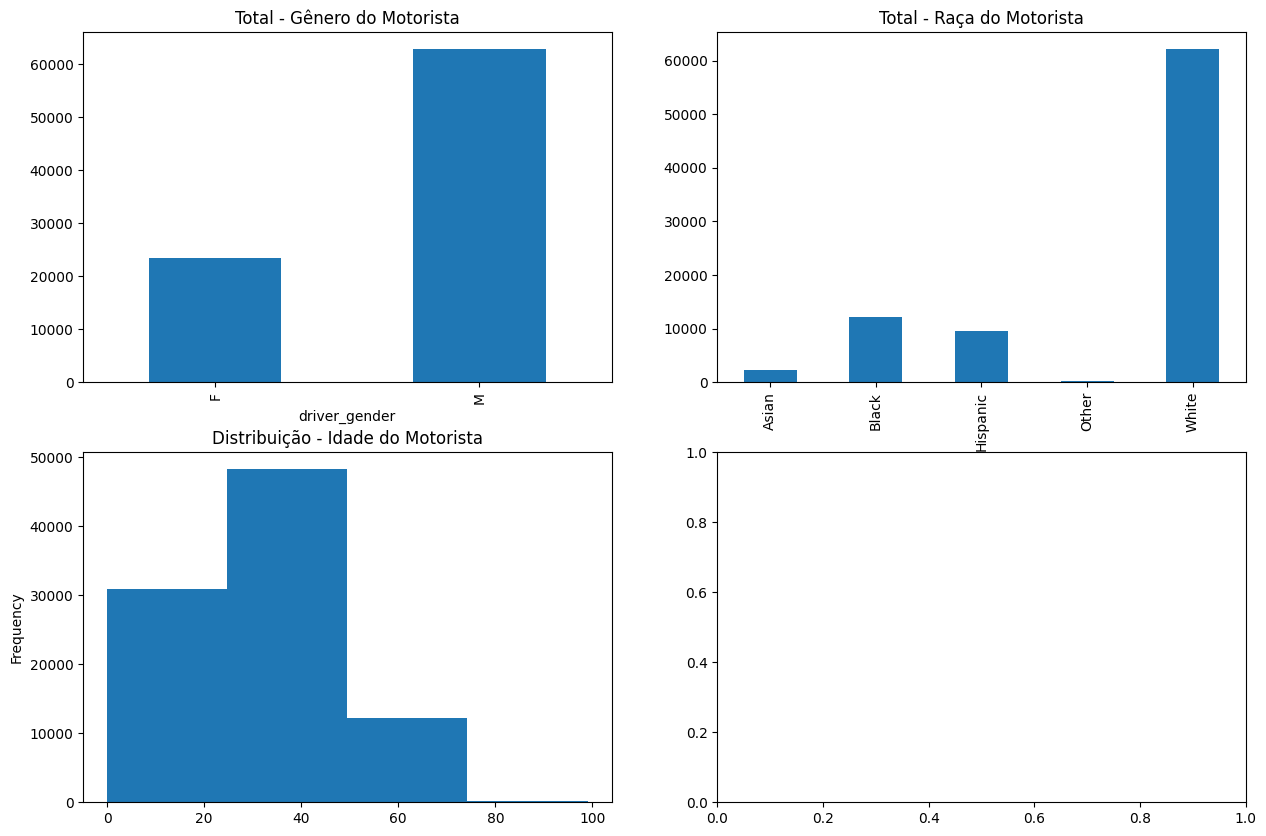

In [25]:
fig, axes = plt.subplots(nrows=2, ncols=2)
# change figure size
fig.set_size_inches(15, 10)

featured_df.groupby("driver_gender")["counter"].count().plot(
    kind="bar", ax=axes[0, 0], title="Total - Gênero do Motorista"
)

featured_df.groupby("driver_race")["counter"].count().plot(
    kind="bar", ax=axes[0, 1], title="Total - Raça do Motorista"
)

featured_df.driver_age.plot.hist(
    bins=4, ax=axes[1, 0], title="Distribuição - Idade do Motorista"
)

In [90]:
arrested_df = featured_df[featured_df.is_arrested == True]
arrested_df["driver_age"] = arrested_df.driver_age.fillna(25)
arrested_df["age_groups"] = pd.qcut(arrested_df["driver_age"], 3)
arrested_per_age_groups = (
    arrested_df.groupby("age_groups").counter.count() / arrested_df.counter.count()
)
arrested_per_age_groups

/var/folders/r2/8046088d6gb009xxzt_ggdch0000gn/T/ipykernel_57587/658376026.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  arrested_df["driver_age"] = arrested_df.driver_age.fillna(25)
/var/folders/r2/8046088d6gb009xxzt_ggdch0000gn/T/ipykernel_57587/658376026.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  arrested_df["age_groups"] = pd.qcut(arrested_df["driver_age"], 3)


age_groups
(-0.001, 25.0]    0.341413
(25.0, 35.0]      0.344828
(35.0, 79.0]      0.313759
Name: counter, dtype: float64

### Conclusões 📝

O perfil que compõe a maior parte do dataset é:
* adulto: 30~ -> 40~ 
* branco 
* homem

Se você é hispânico ou negro você tem duas vezes mais chance de ser preso.

In [26]:
featured_df_cp = featured_df.copy()
featured_df_cp["driver_race"] = featured_df.driver_race.fillna("NA")

arrest_proportional_per_race = {}

for race in featured_df_cp["driver_race"].unique():
    arrest_proportional_per_race[race] = (
        featured_df_cp[
            (featured_df_cp.is_arrested == True) & (featured_df_cp.driver_race == race)
        ].shape[0]
        / featured_df_cp[featured_df_cp.driver_race == race].shape[0]
    ) * 100

arrested_proportional_per_race_df = pd.DataFrame(
    arrest_proportional_per_race, index=[0]
)

<Axes: title={'center': 'Arrested Search Conducted'}, xlabel='search_conducted'>

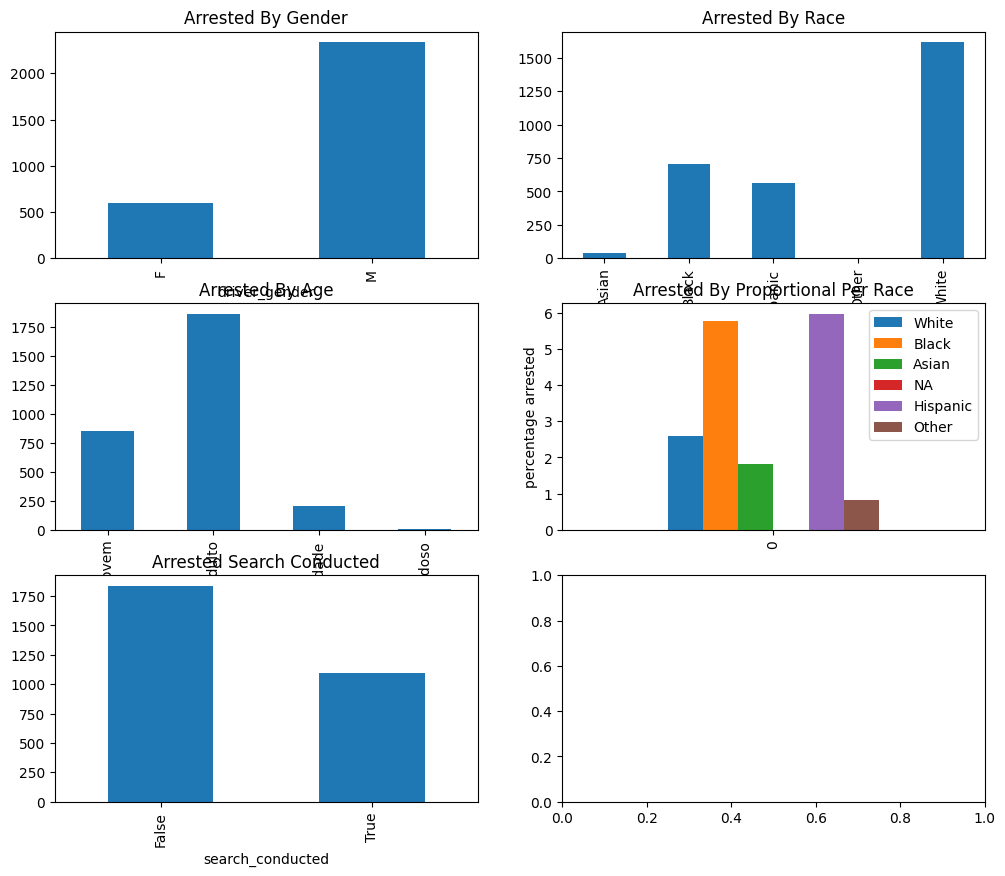

In [27]:
fig, axes = plt.subplots(nrows=3, ncols=2)
# change figure size
fig.set_size_inches(12, 10)

featured_df[featured_df.is_arrested == True].groupby("driver_gender")[
    "counter"
].count().plot(kind="bar", ax=axes[0, 0], title="Arrested By Gender")

featured_df[featured_df.is_arrested == True].groupby("driver_race")[
    "counter"
].count().plot(kind="bar", ax=axes[0, 1], title="Arrested By Race")

featured_df[featured_df.is_arrested == True].groupby("driver_age_bins")[
    "counter"
].count().plot(kind="bar", ax=axes[1, 0], title="Arrested By Age")

arrested_proportional_per_race_df.plot(
    kind="bar",
    ax=axes[1, 1],
    ylabel="percentage arrested",
    title="Arrested By Proportional Per Race",
)
featured_df[featured_df.is_arrested == True].groupby("search_conducted")[
    "counter"
].count().plot(kind="bar", ax=axes[2, 0], title="Arrested Search Conducted")

In [28]:
p_being_arrested = (
    featured_df[featured_df.is_arrested == True].shape[0] / featured_df.shape[0]
)
p_being_arrested_and_black_or_hispanic = (
    featured_df[
        (featured_df.is_arrested == True) & (featured_df.is_black_or_hispanic == True)
    ].shape[0]
    / featured_df.shape[0]
)
p_being_black_or_hispanic = (
    featured_df[featured_df.is_black_or_hispanic == True].shape[0]
    / featured_df.shape[0]
)

p_being_arrested_given_black_or_hispanic = (
    p_being_arrested_and_black_or_hispanic / p_being_black_or_hispanic
)

print(f"Probability of being arrested: {p_being_arrested:.2f}%")
print(
    f"Probability of being arrested given the driver is black or hispanic: {p_being_arrested_given_black_or_hispanic:.2f}%"
)

Probability of being arrested: 0.03%
Probability of being arrested given the driver is black or hispanic: 0.06%


### Conclusões 📝

* A violação com maio número de ocorrências é velocidade.
* Os outcome level das violações estão igualmente distribuídas entre os tipos de violação. Com exceção de:
  * Motorist Assist/Courtesy - O valor abaixo dos outros tipos É esperado uma vez que representa uma boa ação.
  * Warrant - O valor acima dos outros tipos deve ser investigado.  

<Axes: title={'center': 'Violations Outcome Level Median'}, xlabel='violation_raw'>

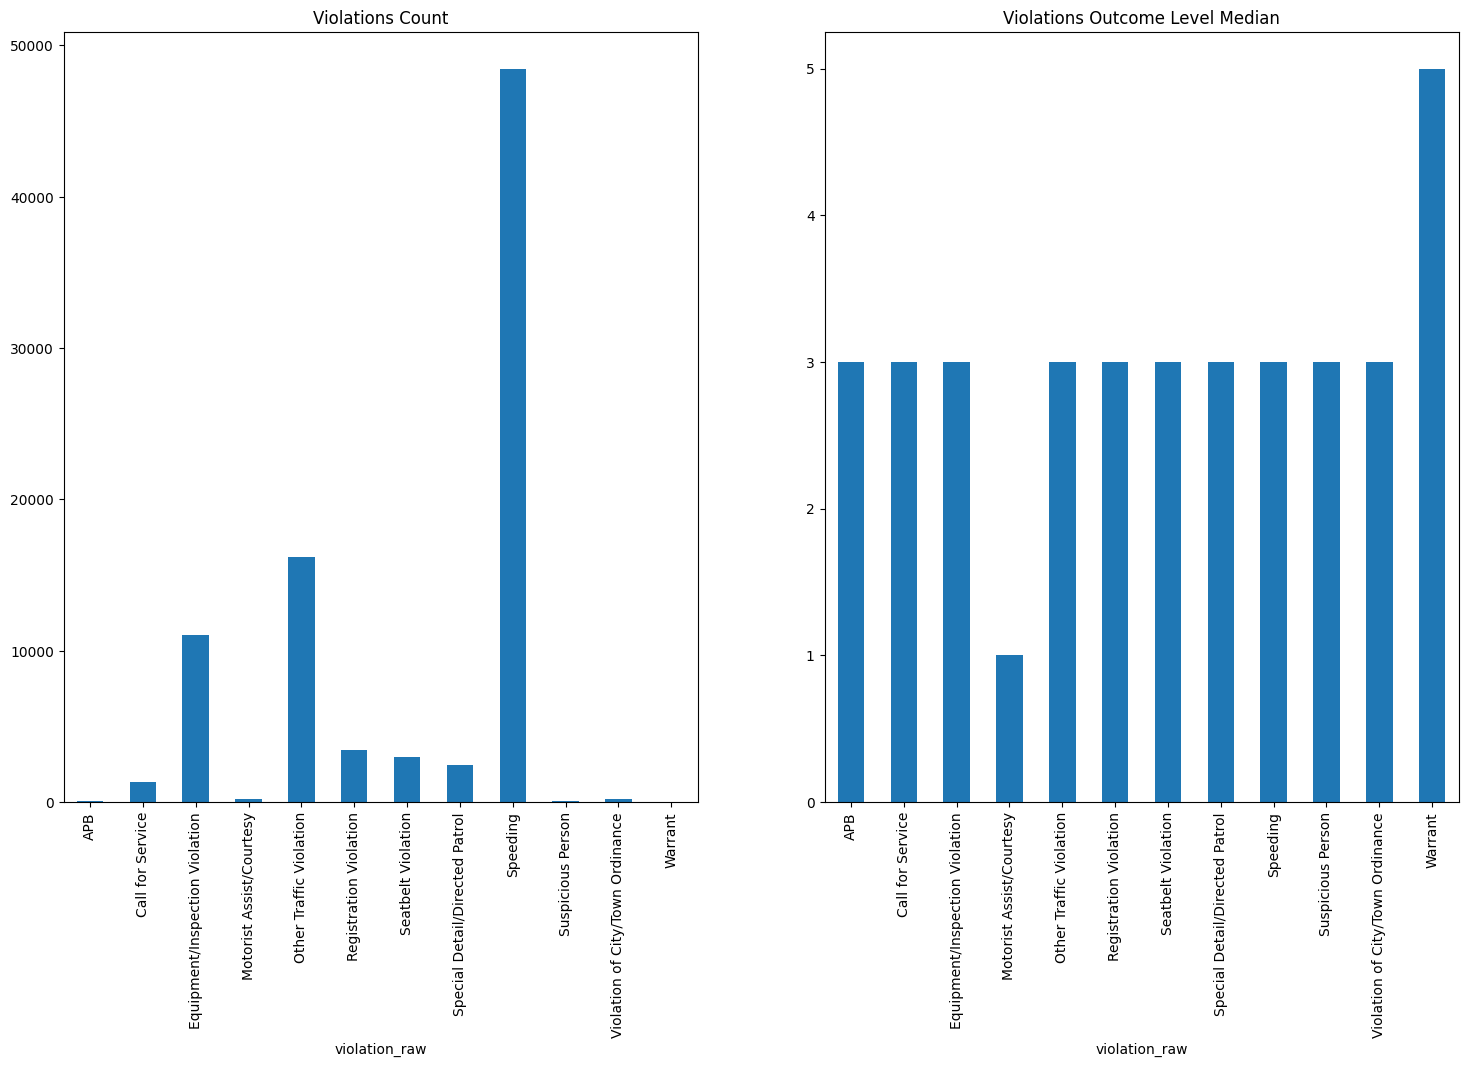

In [29]:
fig, axes = plt.subplots(nrows=1, ncols=2)
# change figure size
fig.set_size_inches(18, 10)


featured_df.groupby("violation_raw")["counter"].count().plot(
    kind="bar", title="Violations Count", ax=axes[0]
)


featured_df.groupby("violation_raw")["stop_outcome_level"].median().plot(
    kind="bar", title="Violations Outcome Level Median", ax=axes[1]
)

### Análise do Search Type 🕵🏻‍♂️ 

['incident_to_arrest',
 'protective_frisk',
 'probable_cause',
 'reasonable_suspicion',
 'inventory',
 'stop_outcome_level',
 'violation_level',
 'search_conducted',
 'drugs_related_stop']

<Axes: >

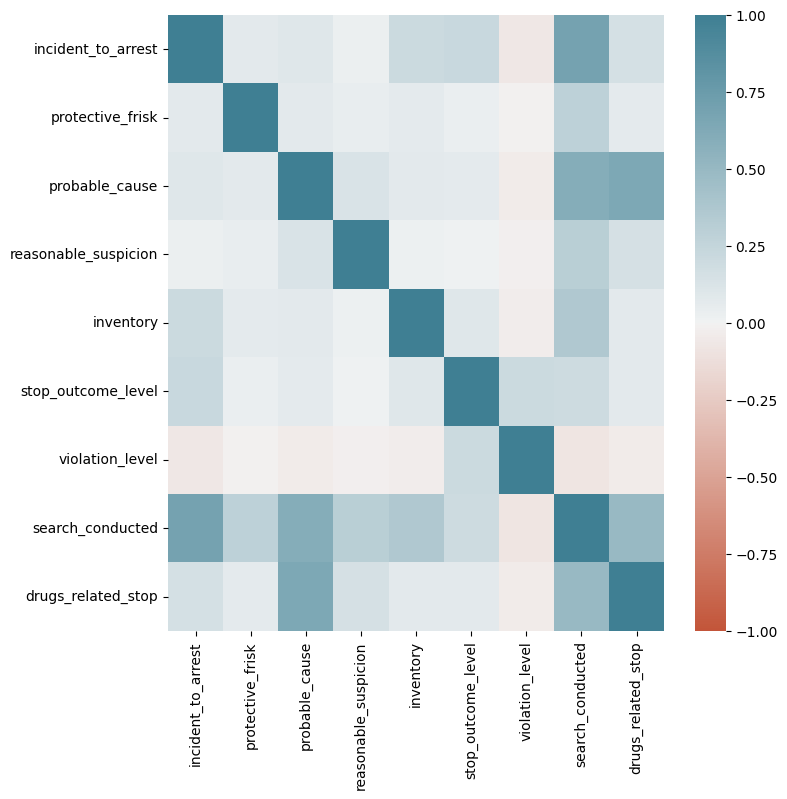

In [30]:
search_type_df_pearson = search_type_df.copy()

features_of_interest = encoded_search_type_features.copy()
for f in [
    "stop_outcome_level",
    "violation_level",
    "search_conducted",
    "drugs_related_stop",
]:
    features_of_interest.append(f)

display(features_of_interest)
search_type_df_pearson = search_type_df_pearson[features_of_interest]

plt.rcParams["figure.figsize"] = (8, 8)
sns.heatmap(
    search_type_df_pearson.corr(),
    vmin=-1,
    vmax=1,
    cmap=sns.diverging_palette(20, 220, as_cmap=True),
)

#### Aplicando Regressão Linear no Search Type 📈

#### Conclusões 📝

* O `search type` que mais está relacionado à prisão é o `indicent to arrest`
* O `search type` que menos está relacionado à prisão, e ao `stop outcome` em geral é o `reasonable suspecion`
* O `search conducted` está fortemente realacionado ao `drugs_related_stop`.
* O `Probable cause` não está fortemente relacionado com o `stop outcome` o que pode indicar que boa parte das buscas de causas prváveis acabam sendo um erro (nenhuma prova é encontrada)
* `Probable cause` também está fortemente relacionado ao `drugs related stop` o que pode indicar que boa parte das buscas de causas prováves (busca de provas) visa o combate às drogas.`

In [31]:
# creating lm dataset
X_st_lm = search_type_df.copy()
display(encoded_search_type_features)
features_of_interest = encoded_search_type_features.copy()
features_of_interest.append("stop_outcome_level")

X_st_lm = X_st_lm[features_of_interest]
y_st_lm = X_st_lm.pop("stop_outcome_level")

['incident_to_arrest',
 'protective_frisk',
 'probable_cause',
 'reasonable_suspicion',
 'inventory']

In [32]:
from sklearn.linear_model import LinearRegression

search_type_lm = LinearRegression()
search_type_lm.fit(X_st_lm, y_st_lm)

print(f"Intercept: {search_type_lm.intercept_:.3f}")
print(f"Coefficients: ")
for name, coef in zip(X_st_lm.columns, search_type_lm.coef_):
    print(f" {name}: {coef}")

Intercept: 2.836
Coefficients: 
 incident_to_arrest: 1.056340923615684
 protective_frisk: 0.16241501106027978
 probable_cause: 0.2609673470438391
 reasonable_suspicion: 0.014136465694004846
 inventory: 0.4628912737696372


## Mais Análises Exploratórias 🧭🗺️

In [33]:
featured_df.describe()

,county_name,driver_age_raw,driver_age,stop_outcome_level,violation_level,proportional_stop_outcome,stop_time_discrete,counter
count,0.0,86414.000000,91741.000000,91741.000000,91741.000000,91741.000000,91741.000000,91741.0
mean,NaN,1970.491228,31.927448,2.860281,3.150445,1.540728,1194.606861,1.0
std,NaN,110.914909,14.793998,0.661906,1.966006,1.181678,651.307607,0.0
min,NaN,0.000000,0.000000,1.000000,1.000000,0.200000,0.000000,1.0
25%,NaN,1967.000000,22.000000,3.000000,1.000000,0.600000,810.000000,1.0
50%,NaN,1980.000000,29.000000,3.000000,5.000000,0.600000,1140.000000,1.0
75%,NaN,1987.000000,42.000000,3.000000,5.000000,3.000000,1635.000000,1.0
max,NaN,8801.000000,99.000000,5.000000,5.000000,5.000000,2359.000000,1.0


In [34]:
# Defining baseline features for comparison

baseline_features = [
    "is_arrested",
    "driver_race",
    "driver_gender",
    "stop_outcome_level",
    "violation_level",
    "search_conducted",
    "search_type",
    "drugs_related_stop",
    "stop_time_discrete_bins",
    "driver_age_bins",
]

In [35]:
def box_plot_by(df_, col):
    box = df_.copy()
    fig_size = (8, 10)

    plt.figure(figsize=fig_size)

    ax = box.boxplot(
        by=col,
        column="stop_outcome_level",
    )

    ax.set_xlabel("")
    ax.set_ylabel("Stop Outcome Level (arrested, warning, citation...)")
    plt.suptitle("Outcome Level by " + col)

    bx = box.boxplot(
        by=col,
        column="violation_level",
    )
    bx.set_xlabel("")
    bx.set_ylabel("Violation Level (Speed, moving violation, ....)")
    plt.suptitle("Violation Level by " + col)

## Correlações 📈 

### Mutual Information

Utilizando mutual information para encontrar correlações não lineares entre as features e o target (stop_outcome_level).

- [mutual information - kaggle article](https://www.kaggle.com/code/ryanholbrook/mutual-information)

In [36]:
X = featured_df.copy()
X = X[baseline_features]
y = X.pop("stop_outcome_level")

In [37]:
# label encoding for categoricals
for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()

X["stop_time_discrete_bins"], _ = X["stop_time_discrete_bins"].factorize()
X["driver_age_bins"], _ = X["driver_age_bins"].factorize()

discrete_features = X.dtypes == int

display(X.head())
display(X["stop_time_discrete_bins"].dtype)

,is_arrested,driver_race,driver_gender,violation_level,search_conducted,search_type,drugs_related_stop,stop_time_discrete_bins,driver_age_bins
0,False,0,0,5,False,-1,False,0,0
1,False,0,0,5,False,-1,False,1,1
2,False,0,0,5,False,-1,False,2,1
3,True,0,0,1,False,-1,False,3,0
4,False,0,1,5,False,-1,False,1,0


dtype('int64')

In [38]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

In [39]:
from sklearn.feature_selection import mutual_info_regression


def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(
        X,
        y,
        discrete_features=discrete_features,
    )
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


mi_scores = make_mi_scores(X, y, discrete_features)
mi_scores[::3]  # show few features with their scores

driver_race         0.202092
violation_level     0.079578
search_conducted    0.026773
Name: MI Scores, dtype: float64

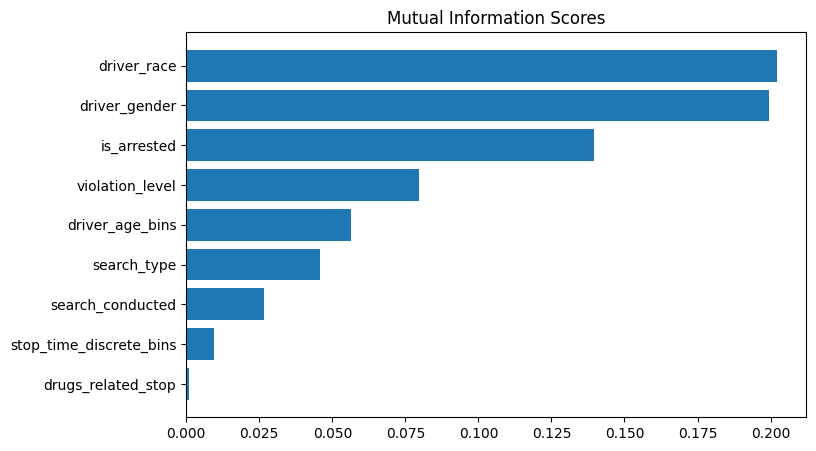

In [40]:
plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

<Axes: >

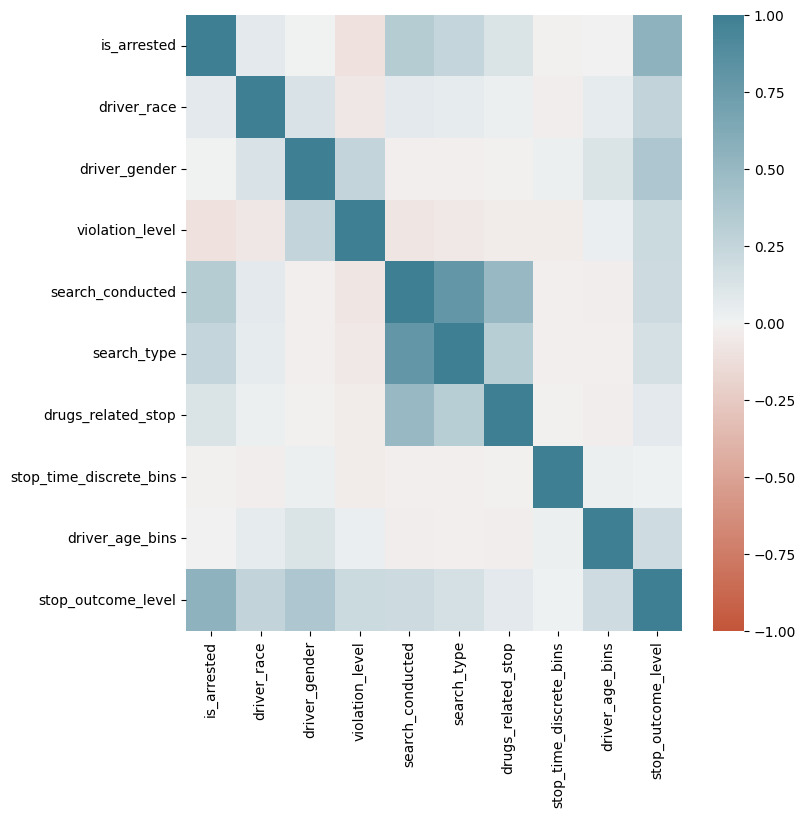

In [41]:
# Correlationa

X_y = X.copy()
X_y["stop_outcome_level"] = y

plt.rcParams["figure.figsize"] = (8, 8)
sns.heatmap(
    X_y.corr(), vmin=-1, vmax=1, cmap=sns.diverging_palette(20, 220, as_cmap=True)
)

## Treinando uma Árvore de Decisão 🌲🌳

Usando uma árvore de decisão para entender como as features mais significantes se correlacionam com o nível do resultado da parada.

#### Conclusões 📝

Podemos ver que no topo da árvore de decisões os atributos que aparecem no topo são:
* `violation_level`
* `driver_race`
* `driver_gender`

In [42]:
from sklearn import tree
from matplotlib import pyplot as plt

selected_features = [
    "driver_race",
    "driver_gender",
    "driver_age_bins",
    "violation_level",
    # "is_black_or_hispanic",
]
X_tree = featured_df.copy()
y_tree = X_tree.pop("is_arrested")
X_tree = pd.get_dummies(X_tree[selected_features], drop_first=False)

display(print(f"Y => {y_tree.hasnans}"))

clf = tree.DecisionTreeClassifier(random_state=0)
clf = clf.fit(X_tree, y_tree)

Y => False


None

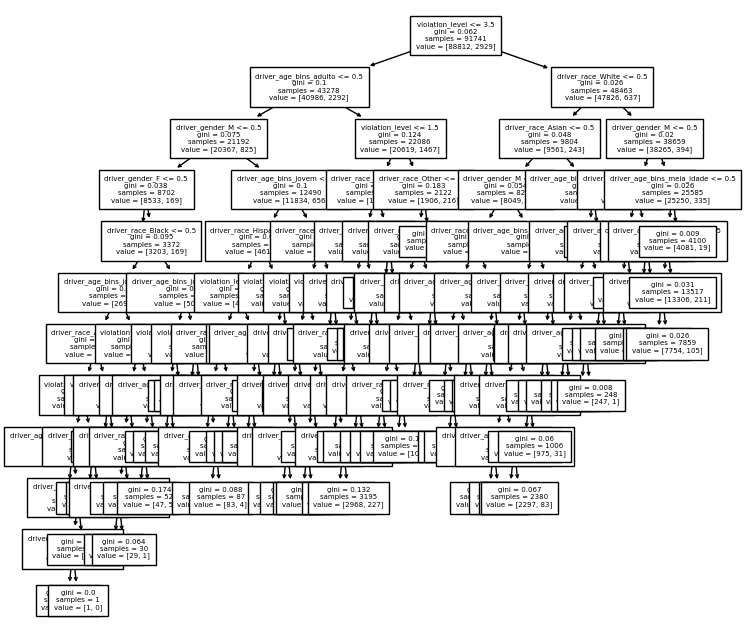

<Figure size 1000x1000 with 0 Axes>

In [43]:
# plt.rcParams["figure.figsize"] = (30,30)
# plt.rcParams["figure.figsize"] = (10,10)
tree.plot_tree(clf, feature_names=X_tree.columns, fontsize=5)
plt.figure(dpi=100, figsize=(10, 10))
plt.show()

## Análise dos Coeficientes da Regressão Linear 📈🧪

#### Conclusões 📝

* Podemos ver que os coeficientes da regressão linear com os valores mais confiáveis (menor valor de P>|t|) são os coeficientes relacionados à raça
* As raças negras e hispânicas têm correlação ligeiramente maior com o nível de resultado da parada do que as outras raças.

In [44]:
# creating lm dataset
X_lm = featured_df.copy()
y_lm = X_lm.pop("stop_outcome_level")

# selecting lm features
lm_features = [
    "driver_race",
    "driver_gender",
    "driver_age_bins",
    "violation_level",
    "search_conducted",
    "drugs_related_stop",
]

for bool_col in ["search_conducted", "drugs_related_stop"]:
    X_lm[bool_col] = X_lm[bool_col].astype("str")

# getting categorical features dummies
X_lm = pd.get_dummies(X_lm[lm_features], drop_first=False)

X_lm.head()

,violation_level,driver_race_Asian,driver_race_Black,driver_race_Hispanic,driver_race_Other,driver_race_White,driver_gender_F,driver_gender_M,driver_age_bins_jovem,driver_age_bins_adulto,driver_age_bins_meia_idade,driver_age_bins_idoso,search_conducted_False,search_conducted_True,drugs_related_stop_False,drugs_related_stop_True
0,5,False,False,False,False,True,False,True,True,False,False,False,True,False,True,False
1,5,False,False,False,False,True,False,True,False,True,False,False,True,False,True,False
2,5,False,False,False,False,True,False,True,False,True,False,False,True,False,True,False
3,1,False,False,False,False,True,False,True,True,False,False,False,True,False,True,False
4,5,False,False,False,False,True,True,False,True,False,False,False,True,False,True,False


In [45]:
from sklearn.linear_model import LinearRegression

police_stop_lm = LinearRegression()
police_stop_lm.fit(X_lm, y_lm)

print(f"Intercept: {police_stop_lm.intercept_:.3f}")
print(f"Coefficients: ")
for name, coef in zip(X_lm.columns, police_stop_lm.coef_):
    print(f" {name}: {coef}")

Intercept: -14572561076.186
Coefficients: 
 violation_level: 0.014661701636678804
 driver_race_Asian: 1.4381177667984368
 driver_race_Black: 1.4552702406044604
 driver_race_Hispanic: 1.4618536787342788
 driver_race_Other: 1.375729013586228
 driver_race_White: 1.4331522356985946
 driver_gender_F: 0.4631743710888586
 driver_gender_M: 0.4848465566088227
 driver_age_bins_jovem: 79968491.21609595
 driver_age_bins_adulto: 79968491.2243004
 driver_age_bins_meia_idade: 79968491.1932562
 driver_age_bins_idoso: 79968491.04616134
 search_conducted_False: 1407578695.0263271
 search_conducted_True: 1407578695.691715
 drugs_related_stop_False: 13085013890.928486
 drugs_related_stop_True: 13085013890.69417


In [46]:
from statsmodels.regression.linear_model import OLS

model = OLS(y_lm, X_lm.astype(float))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     stop_outcome_level   R-squared:                       0.356
Model:                            OLS   Adj. R-squared:                  0.356
Method:                 Least Squares   F-statistic:                     3629.
Date:                Wed, 16 Aug 2023   Prob (F-statistic):               0.00
Time:                        19:57:03   Log-Likelihood:                -72101.
No. Observations:               91741   AIC:                         1.442e+05
Df Residuals:                   91726   BIC:                         1.444e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
violation_level                0.0156      0.001     13.829      0.000       0.013       0.018
driver_race_Asian              1.4328      0.376      3.813      0.000       0.696       2.169
driver_race_Black              1.4585      0.376      3.883      0.000       0.722       2.195
driver_race_Hispanic           1.4682      0.376      3.908      0.000       0.732       2.204
driver_race_Other              1.3801      0.377      3.659      0.000       0.641       2.119
driver_race_White              1.4318      0.376      3.812      0.000       0.696       2.168
driver_gender_F                0.4631      0.376      1.233      0.217      -0.273       1.199
driver_gender_M                0.4847      0.376      1.291      0.197      -0.251       1.221
driver_age_bins_jovem      -6.292e+09    8.5e+09     -0.740      0.459    -2.3e+10    1.04e+10
driver_age_bins_adulto     -6.292e+09    8.5e+09     -0.740      0.459    -2.3e+10    1.04e+10
driver_age_bins_meia_idade -6.292e+09    8.5e+09     -0.740      0.459    -2.3e+10    1.04e+10
driver_age_bins_idoso      -6.292e+09    8.5e+09     -0.740      0.459    -2.3e+10    1.04e+10
search_conducted_False       1.73e+11   9.02e+10      1.917      0.055   -3.88e+09     3.5e+11
search_conducted_True        1.73e+11   9.02e+10      1.917      0.055   -3.88e+09     3.5e+11
drugs_related_stop_False   -1.667e+11   8.71e+10     -1.912      0.056   -3.37e+11    4.15e+09
drugs_related_stop_True    -1.667e+11   8.71e+10     -1.912      0.056   -3.37e+11    4.15e+09
==============================================================================
Omnibus:                    17576.968   Durbin-Watson:                   1.440
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           449533.957
Skew:                           0.251   Prob(JB):                         0.00
Kurtosis:                      13.833   Cond. No.                     4.10e+14
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 8.97e-24. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""